# Farm Bora Model Training

## 0. Configure Environment

In [1]:
import torch

# Check PyTorch version
pt_version = torch.__version__
print(f"[INFO] Current PyTorch version: {pt_version} (should be 2.x+)")

# Install PyTorch 2.0 if necessary
if pt_version.split(".")[0] == "1": # Check if PyTorch version begins with 1 
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    print("[INFO] PyTorch 2.x installed. Restart the kernel to pick the new changes.")
    import torch
    pt_version = torch.__version__
    print(f"[INFO] Current PyTorch version: {pt_version} (should be 2.x+)")
else:
    print("[INFO] PyTorch 2.x installed, you'll be able to use the new features.")

[INFO] Current PyTorch version: 2.0.1+cu118 (should be 2.x+)
[INFO] PyTorch 2.x installed, you'll be able to use the new features.


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.


In [3]:
torch.__version__, torchvision.__version__

('2.0.1+cu118', '0.15.2+cu118')

In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
RANDOM_SEED = 42
NUM_EPOCHS = 32

## 1. Get the Data

### 1.1 Download the dataset

In [6]:
from pathlib import Path

url = "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded"

# To access persistent storage in Paper space
root_storage = "/storage/"

data_path = Path(f"{root_storage}data/")
destination_path = "plant_village"
image_path = data_path / destination_path

In [9]:
from tqdm.auto import tqdm

import os
import shutil
import zipfile
import requests

if image_path.is_dir():
    print(f"[INFO] {image_path} exists. Skipping...")
else:
    print(f"[INFO] {image_path} not found. Creating...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download the dataset
    target_file = Path(destination_path + ".zip")

    print(f"[INFO] Downloading {target_file} from {url}...")

    with requests.get(url, stream=True) as r:
        # check header to get content length, in bytes
        total_length = int(r.headers.get("Content-Length"))

        # implement progress bar via tqdm
        with tqdm.wrapattr(r.raw, "read", total=total_length, desc="") as raw:
            with open(data_path / target_file, "wb") as f:
                shutil.copyfileobj(raw, f)
    
    # Unzip the dataset
    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
        print(f"[INFO] Unzipping {target_file} data...")
        zip_ref.extractall(image_path)
        
    os.remove(data_path / target_file)

[INFO] /storage/data/plant_village not found. Creating...
[INFO] Downloading plant_village.zip from https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded...


  0%|          | 0/949267727 [00:00<?, ?it/s]

[INFO] Unzipping plant_village.zip data...


In [13]:
# !rm -rf /storage/data/plant_village*
# !ls /storage/data
!ls /storage/data/plant_village/Plant_leave_diseases_dataset_with_augmentation

 Apple___Apple_scab
 Apple___Black_rot
 Apple___Cedar_apple_rust
 Apple___healthy
 Background_without_leaves
 Blueberry___healthy
 Cherry___Powdery_mildew
 Cherry___healthy
'Corn___Cercospora_leaf_spot Gray_leaf_spot'
 Corn___Common_rust
 Corn___Northern_Leaf_Blight
 Corn___healthy
 Grape___Black_rot
'Grape___Esca_(Black_Measles)'
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
 Grape___healthy
'Orange___Haunglongbing_(Citrus_greening)'
 Peach___Bacterial_spot
 Peach___healthy
 Pepper,_bell___Bacterial_spot
 Pepper,_bell___healthy
 Potato___Early_blight
 Potato___Late_blight
 Potato___healthy
 Raspberry___healthy
 Soybean___healthy
 Squash___Powdery_mildew
 Strawberry___Leaf_scorch
 Strawberry___healthy
 Tomato___Bacterial_spot
 Tomato___Early_blight
 Tomato___Late_blight
 Tomato___Leaf_Mold
 Tomato___Septoria_leaf_spot
'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___Target_Spot
 Tomato___Tomato_Yellow_Leaf_Curl_Virus
 Tomato___Tomato_mosaic_virus
 Tomato___healthy


### 1.2 Organize the data

In [13]:
dataset_dir = image_path / "Plant_leave_diseases_dataset_with_augmentation"

In [14]:
all_image_paths = list(dataset_dir.glob("*/*.JPG"))
len(all_image_paths), all_image_paths[:3]

(58775,
 [PosixPath('/storage/data/plant_village/Plant_leave_diseases_dataset_with_augmentation/Corn___Northern_Leaf_Blight/image (340).JPG'),
  PosixPath('/storage/data/plant_village/Plant_leave_diseases_dataset_with_augmentation/Corn___Northern_Leaf_Blight/image (208).JPG'),
  PosixPath('/storage/data/plant_village/Plant_leave_diseases_dataset_with_augmentation/Corn___Northern_Leaf_Blight/image (754).JPG')])

Obtain the unique class names

In [15]:
from tqdm.auto import tqdm

class_names = set()

for path in tqdm(all_image_paths):
    class_names.add(Path(path).parent.stem)

class_names = list(class_names)
len(class_names), class_names[:3]

  0%|          | 0/58775 [00:00<?, ?it/s]

(38,
 ['Cherry___healthy', 'Grape___Esca_(Black_Measles)', 'Potato___Early_blight'])

Now let's see how many samples we have per class

In [17]:
class_images = {}
for class_name in tqdm(class_names):
    class_images[class_name] = list(dataset_dir.glob(f"{class_name}/*.JPG"))

min_class = {"key": "", "samples": "" }
max_class = {"key": "", "samples": "" }
for key, samples in class_images.items():
    # Initialize the min and max classes
    min_class["key"] = key if not min_class["key"] else min_class["key"]
    min_class["samples"] = len(samples) if min_class["samples"] == "" else min_class["samples"]
    
    max_class["key"] = key if not max_class["key"] else max_class["key"]
    max_class["samples"] = len(samples) if max_class["samples"] == "" else max_class["samples"]
    
    if len(samples) < min_class["samples"]:
        min_class["key"]  = key
        min_class["samples"] = len(samples)
    
    if len(samples) > max_class["samples"]:
        max_class["key"]  = key
        max_class["samples"] = len(samples)
    
    print(f"{key}: {len(samples)}")

min_class, max_class

  0%|          | 0/38 [00:00<?, ?it/s]

Tomato___Tomato_Yellow_Leaf_Curl_Virus: 5357
Tomato___Bacterial_spot: 2127
Grape___Black_rot: 1180
Blueberry___healthy: 1502
Pepper,_bell___Bacterial_spot: 1000
Tomato___Early_blight: 1000
Apple___healthy: 1645
Orange___Haunglongbing_(Citrus_greening): 5507
Pepper,_bell___healthy: 1476
Strawberry___healthy: 1000
Tomato___Spider_mites Two-spotted_spider_mite: 1676
Potato___healthy: 1000
Tomato___Late_blight: 1756
Tomato___healthy: 1590
Tomato___Target_Spot: 1404
Corn___healthy: 21
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076
Cherry___healthy: 1000
Apple___Apple_scab: 1000
Cherry___Powdery_mildew: 1052
Potato___Late_blight: 1000
Grape___healthy: 1000
Tomato___Septoria_leaf_spot: 1771
Squash___Powdery_mildew: 1813
Tomato___Leaf_Mold: 1000
Peach___Bacterial_spot: 2297
Potato___Early_blight: 1000
Raspberry___healthy: 1000
Corn___Northern_Leaf_Blight: 882
Corn___Common_rust: 1192
Strawberry___Leaf_scorch: 1108
Apple___Black_rot: 1000
Corn___Cercospora_leaf_spot Gray_leaf_spot: 870
Apple_

({'key': 'Corn___healthy', 'samples': 21},
 {'key': 'Orange___Haunglongbing_(Citrus_greening)', 'samples': 5507})

The dataset is severly imbalanced. That's a future problem though

In [26]:
TEST_PC = 25
TRAIN_PC = 75

test_paths = []
train_paths = []

for key, samples in tqdm(class_images.items()):
    samples_count = len(samples)
    test_count = round(samples_count * TEST_PC / 100)
    train_count = round(samples_count * TRAIN_PC / 100)
    
    print(f"Splitting {key} to Train ({train_count}), Test ({test_count})")
    test_paths += samples[:test_count]
    train_paths += samples[test_count:]

len(test_paths), len(train_paths)

  0%|          | 0/38 [00:00<?, ?it/s]

Splitting Tomato___Tomato_Yellow_Leaf_Curl_Virus to Train (4018), Test (1339)
Splitting Tomato___Bacterial_spot to Train (1595), Test (532)
Splitting Grape___Black_rot to Train (885), Test (295)
Splitting Blueberry___healthy to Train (1126), Test (376)
Splitting Pepper,_bell___Bacterial_spot to Train (750), Test (250)
Splitting Tomato___Early_blight to Train (750), Test (250)
Splitting Apple___healthy to Train (1234), Test (411)
Splitting Orange___Haunglongbing_(Citrus_greening) to Train (4130), Test (1377)
Splitting Pepper,_bell___healthy to Train (1107), Test (369)
Splitting Strawberry___healthy to Train (750), Test (250)
Splitting Tomato___Spider_mites Two-spotted_spider_mite to Train (1257), Test (419)
Splitting Potato___healthy to Train (750), Test (250)
Splitting Tomato___Late_blight to Train (1317), Test (439)
Splitting Tomato___healthy to Train (1192), Test (398)
Splitting Tomato___Target_Spot to Train (1053), Test (351)
Splitting Corn___healthy to Train (16), Test (5)
Splittin

(14694, 44081)

In [7]:
organized_dir = image_path / "organized"
train_dir = organized_dir / "train"
test_dir = organized_dir / "test"
train_dir, test_dir

(PosixPath('/storage/data/plant_village/organized/train'),
 PosixPath('/storage/data/plant_village/organized/test'))

In [46]:
# !rm -rf /storage/data/plant_village/Plant_leave_diseases_dataset_with_augmentation/organized

In [51]:
import shutil

if not train_dir.is_dir():
    train_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"[INFO] Copying train datasets")
    
    for img_path in tqdm(train_paths):
        class_name = img_path.parent.stem
        class_dir = train_dir / class_name
        if not class_dir.is_dir():
            class_dir.mkdir(parents=True, exist_ok=True)
        
        shutil.copyfile(img_path, class_dir / img_path.name)
        
!ls /storage/data/plant_village/organized

train


In [52]:
import shutil

if not test_dir.is_dir():
    test_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"[INFO] Copying train datasets")
    
    for img_path in tqdm(test_paths):
        class_name = img_path.parent.stem
        class_dir = test_dir / class_name
        if not class_dir.is_dir():
            class_dir.mkdir(parents=True, exist_ok=True)
        
        shutil.copyfile(img_path, class_dir / img_path.name)
        
!ls /storage/data/plant_village/organized

[INFO] Copying train datasets


  0%|          | 0/14694 [00:00<?, ?it/s]

test  train


So we have train and test images. Nice. Let's see how it looks

In [42]:
train_image_paths, test_image_paths = list(train_dir.glob("*/*.JPG")), list(test_dir.glob("*/*.JPG"))
len(train_image_paths), len(test_image_paths)

(44081, 14694)

Good. Now We can train the model

## 2. Create and Train EffNetB2

In [26]:
def create_effnetb2_model(num_classes:int=38, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

In [27]:
NUM_CLASSES = len(class_names)
NUM_CLASSES

38

In [28]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=NUM_CLASSES,
                                                      seed=RANDOM_SEED)

In [29]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output) 
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 38]              --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [30]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

Train the model

In [31]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5890 | train_acc: 0.8748 | test_loss: 0.2151 | test_acc: 0.9465
Epoch: 2 | train_loss: 0.2261 | train_acc: 0.9383 | test_loss: 0.1510 | test_acc: 0.9595
Epoch: 3 | train_loss: 0.1831 | train_acc: 0.9449 | test_loss: 0.1225 | test_acc: 0.9653
Epoch: 4 | train_loss: 0.1628 | train_acc: 0.9506 | test_loss: 0.1137 | test_acc: 0.9658
Epoch: 5 | train_loss: 0.1551 | train_acc: 0.9510 | test_loss: 0.1072 | test_acc: 0.9677
Epoch: 6 | train_loss: 0.1453 | train_acc: 0.9527 | test_loss: 0.1005 | test_acc: 0.9690
Epoch: 7 | train_loss: 0.1418 | train_acc: 0.9549 | test_loss: 0.1042 | test_acc: 0.9679
Epoch: 8 | train_loss: 0.1380 | train_acc: 0.9548 | test_loss: 0.0995 | test_acc: 0.9679
Epoch: 9 | train_loss: 0.1345 | train_acc: 0.9560 | test_loss: 0.0950 | test_acc: 0.9682
Epoch: 10 | train_loss: 0.1325 | train_acc: 0.9560 | test_loss: 0.0934 | test_acc: 0.9707


## 3 Inspect loss curves

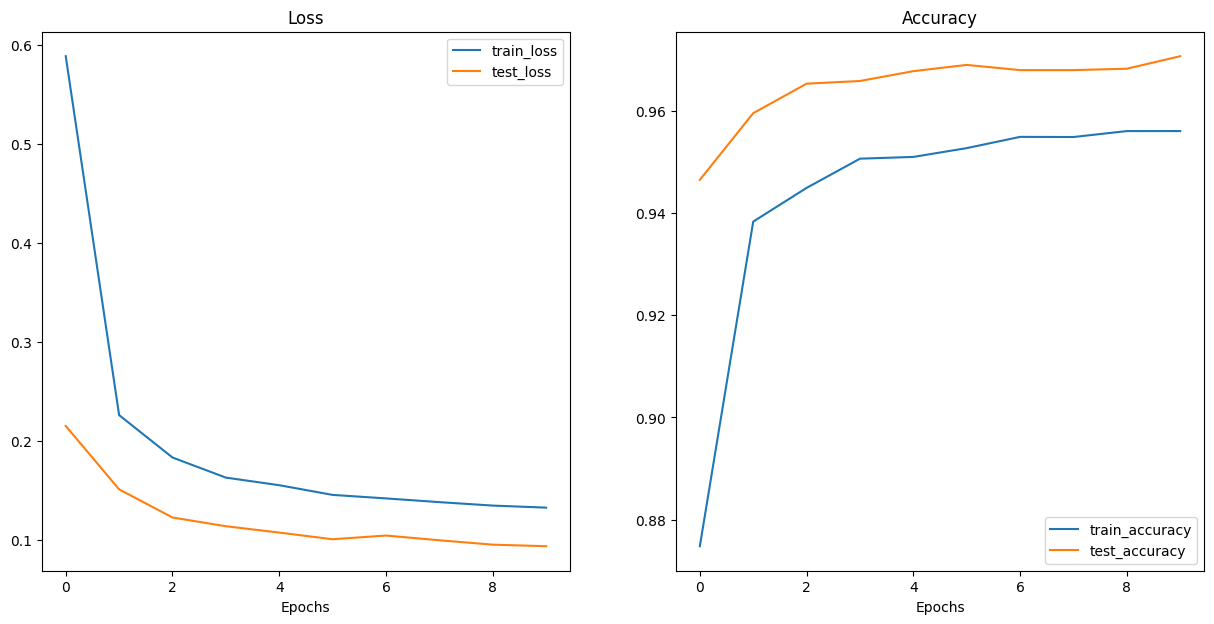

In [33]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

## 4. Save the Model

In [34]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir=image_path / "models",
                 model_name="effnetb2_feature_extractor.pth")

[INFO] Saving model to: /storage/data/plant_village/models/effnetb2_feature_extractor.pth


In [36]:
!ls -lh /storage/data/plant_village/models/effnetb2_feature_extractor.pth

-rw-r--r-- 1 root root 31M Sep  9 23:58 /storage/data/plant_village/models/effnetb2_feature_extractor.pth


## 5. Model Deployment

Create the deployment directory

In [41]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
demo_path = Path("demos/leaf_disease/")

# Remove files that might already exist there and create new directory
if demo_path.exists():
    shutil.rmtree(demo_path)
    demo_path.mkdir(parents=True,
                    exist_ok=True)
else:
    # If the file doesn't exist, create it anyway
    demo_path.mkdir(parents=True,
                    exist_ok=True)
    
# Check what's in the folder
!ls demos

leaf_disease


Store example images

In [46]:
import random

random.seed(RANDOM_SEED)
example_paths = random.sample(test_image_paths, k=10)
example_paths

[PosixPath('/storage/data/plant_village/organized/test/Strawberry___healthy/image (999).JPG'),
 PosixPath('/storage/data/plant_village/organized/test/Tomato___Spider_mites Two-spotted_spider_mite/image (581).JPG'),
 PosixPath('/storage/data/plant_village/organized/test/Pepper,_bell___healthy/image (419).JPG'),
 PosixPath('/storage/data/plant_village/organized/test/Peach___Bacterial_spot/image (472).JPG'),
 PosixPath('/storage/data/plant_village/organized/test/Apple___healthy/image (519).JPG'),
 PosixPath('/storage/data/plant_village/organized/test/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (675).JPG'),
 PosixPath('/storage/data/plant_village/organized/test/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (4735).JPG'),
 PosixPath('/storage/data/plant_village/organized/test/Tomato___Late_blight/image (1363).JPG'),
 PosixPath('/storage/data/plant_village/organized/test/Peach___Bacterial_spot/image (2200).JPG'),
 PosixPath('/storage/data/plant_village/organized/test/Tomato___Spider_mites Two

In [47]:
import shutil
import random
from pathlib import Path

random.seed(RANDOM_SEED)

# 1. Create an examples directory
examples_path = demo_path / "examples"
examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
examples = random.sample(test_image_paths, k=10)

# 3. Copy the three random images to the examples directory
for example in examples:
    destination = examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying /storage/data/plant_village/organized/test/Strawberry___healthy/image (999).JPG to demos/leaf_disease/examples/image (999).JPG
[INFO] Copying /storage/data/plant_village/organized/test/Tomato___Spider_mites Two-spotted_spider_mite/image (581).JPG to demos/leaf_disease/examples/image (581).JPG
[INFO] Copying /storage/data/plant_village/organized/test/Pepper,_bell___healthy/image (419).JPG to demos/leaf_disease/examples/image (419).JPG
[INFO] Copying /storage/data/plant_village/organized/test/Peach___Bacterial_spot/image (472).JPG to demos/leaf_disease/examples/image (472).JPG
[INFO] Copying /storage/data/plant_village/organized/test/Apple___healthy/image (519).JPG to demos/leaf_disease/examples/image (519).JPG
[INFO] Copying /storage/data/plant_village/organized/test/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (675).JPG to demos/leaf_disease/examples/image (675).JPG
[INFO] Copying /storage/data/plant_village/organized/test/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (47

Copy the model to the destination directory

In [49]:
import shutil

# Create a source path for our target model
model_path = "/storage/data/plant_village/models/effnetb2_feature_extractor.pth"

# Create a destination path for our target model 
model_destination = demo_path / model_path.split("/")[-1]


print(f"[INFO] Attempting to copy {model_path} to {model_destination}")

# Move the model
shutil.copy(src=model_path, 
            dst=model_destination)

print(f"[INFO] Model copy complete.")

[INFO] Attempting to copy /storage/data/plant_village/models/effnetb2_feature_extractor.pth to demos/leaf_disease/effnetb2_feature_extractor.pth
[INFO] Model copy complete.


Create a models.py for gradio

In [50]:
%%writefile demos/leaf_disease/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=38, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing demos/leaf_disease/model.py


Create accompanying app.py

In [52]:
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Lea

In [54]:
%%writefile demos/leaf_disease/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['Apple___Apple_scab',
               'Apple___Black_rot',
               'Apple___Cedar_apple_rust',
               'Apple___healthy',
               'Blueberry___healthy',
               'Cherry___Powdery_mildew',
               'Cherry___healthy',
               'Corn___Cercospora_leaf_spot Gray_leaf_spot',
               'Corn___Common_rust',
               'Corn___Northern_Leaf_Blight',
               'Corn___healthy',
               'Grape___Black_rot',
               'Grape___Esca_(Black_Measles)',
               'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
               'Grape___healthy',
               'Orange___Haunglongbing_(Citrus_greening)',
               'Peach___Bacterial_spot',
               'Peach___healthy',
               'Pepper,_bell___Bacterial_spot',
               'Pepper,_bell___healthy',
               'Potato___Early_blight',
               'Potato___Late_blight',
               'Potato___healthy',
               'Raspberry___healthy',
               'Soybean___healthy',
               'Squash___Powdery_mildew',
               'Strawberry___Leaf_scorch',
               'Strawberry___healthy',
               'Tomato___Bacterial_spot',
               'Tomato___Early_blight',
               'Tomato___Late_blight',
               'Tomato___Leaf_Mold',
               'Tomato___Septoria_leaf_spot',
               'Tomato___Spider_mites Two-spotted_spider_mite',
               'Tomato___Target_Spot',
               'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
               'Tomato___Tomato_mosaic_virus',
               'Tomato___healthy']


### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=38, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="effnetb2_feature_extractor.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "LeafDisease v0.1"
description = "An EfficientNetB2 feature extractor trained on the PlantVillage dataset"
article = "Created by c3n7"

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/leaf_disease/app.py


In [55]:
%%writefile demos/leaf_disease/requirements.txt
torch==2.0.1
torchvision==1.15.2
gradio==3.1.4

Writing demos/leaf_disease/requirements.txt


In [56]:
!ls demos/leaf_disease

app.py	effnetb2_feature_extractor.pth	examples  model.py  requirements.txt


In [58]:
!cd demos/leaf_disease && zip -r ../leaf_disease.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 65%)
  adding: effnetb2_feature_extractor.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: examples/image (1574).JPG (deflated 1%)
  adding: examples/image (519).JPG (deflated 2%)
  adding: examples/image (4735).JPG (deflated 2%)
  adding: examples/image (2200).JPG (deflated 1%)
  adding: examples/image (581).JPG (deflated 2%)
  adding: examples/image (419).JPG (deflated 2%)
  adding: examples/image (1363).JPG (deflated 2%)
  adding: examples/image (472).JPG (deflated 2%)
  adding: examples/image (675).JPG (deflated 1%)
  adding: examples/image (999).JPG (deflated 1%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 2%)
